In [1]:
# IRL AutoRegressive 6
# This is the same algorithm as AutoReg 5, but during the training, if the eigenvalues of one feature converges to zero,
# the training continues while locking the weights for that feature.

In [2]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import *
from scipy.optimize import minimize
from scipy.optimize import Bounds

In [3]:
nx = 4
nu = 2
T = 40
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs_act = 1
obs0 = Obstacle(10, 8, 2, obs_act, 'Obs0')
obs1 = Obstacle(3, 2.5, 1, obs_act, 'Obs1')
obs2 = Obstacle(8, 7, 1, obs_act, 'Obs2')
obs3 = Obstacle(4.5, 7, 1, obs_act, 'Obs3')
obs4 = Obstacle(6, 4.5, 1, obs_act, 'Obs4')
obs5 = Obstacle(6.5, 9, 1, obs_act, 'Obs5')
obs6 = Obstacle(7.5, 3, 1, obs_act, 'Obs6')
obs7 = Obstacle(5, 1, 1, obs_act, 'Obs7')
obs8 = Obstacle(2.5, 2, 1, obs_act, 'Obs8')
obs_set = [obs1, obs2, obs3]#, obs4, obs5, obs6, obs7, obs8]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)
# cost_set.add_cost(obs4)
# cost_set.add_cost(obs5)
# cost_set.add_cost(obs6)
# cost_set.add_cost(obs7)
# cost_set.add_cost(obs8)

nr = cost_set.nr

In [4]:
# Desired Weights
w_run_possibles = np.array([10, 1., 1., 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000])
w_term_possibles = np.array([2000, 1., 1., 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])
w_run = w_run_possibles[:nr]
w_term = w_term_possibles[:nr]
obs_set = obs_set[:nr]
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()

In [5]:
samples = 10
xlims = [0, 10]
ylims = [0, 10]
x0 = start_point
u0 = np.array([0.0, 0.0])
timeStep = 5e-2
max_iter = 500
# XS_Set_optimal, US_Set_optimal = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_des, timeStep, max_iter, with_callback = False)
# xs_optimal = XS_Set_optimal[0]
# us_optimal = US_Set_optimal[0]
xs_optimal, us_optimal, _ = get_results_from_model(cost_set, x0, u0, T, w_des, timeStep, max_iter, with_callback = True)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.01000e+02  1.01000e+02  3.46624e+01  1.0000  0.00000e+00  9.96889e+00
   2  1.23346e+00  1.23346e+00  2.68043e+01  0.5000  2.68674e-14  3.88161e-01
   3  1.10462e+00  1.10462e+00  1.05886e+01  1.0000  3.17372e-08  6.81804e-02
   4  1.05873e+00  1.05873e+00  3.63198e+00  1.0000  1.98759e-08  2.36897e-02
   5  9.86632e-01  9.86632e-01  2.29585e+00  1.0000  7.14584e-09  1.46572e-02
   6  9.82170e-01  9.82170e-01  8.56072e-01  1.0000  4.45125e-09  3.12253e-03
   7  9.81945e-01  9.81945e-01  4.12706e-02  1.0000  1.53541e-09  2.37077e-04
 END  9.81944e-01  9.81944e-01  3.38650e-04   ----   6.75099e-11  1.37485e-06


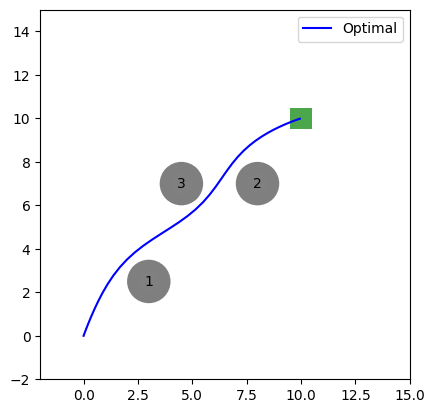

In [6]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(np.vstack(xs_optimal), obs_set, target_high, label='Optimal', linemap = 'b')

In [7]:
# Bad Running and Terminal Model
w_bad = np.zeros_like(w_des)
w_run = w_bad[:nr]
w_term = w_bad[nr:]

xs_non_optimal, us_non_optimal, sqp_non_opt = get_results_from_model(cost_set, x0, u0, T, w_bad, timeStep, max_iter, with_callback = False)

In [8]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())
# plot_1_traj(np.vstack(xs_non_optimal), obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [9]:
# IRL Algorithm
def pick_highs(opt_vals, num):
    vals = np.stack(opt_vals)
    inds = sorted(range(len(vals)), key=lambda i: vals[i])[-num:][::-1]
    return inds

def pick_lows(opt_vals, num):
    vals = np.stack(opt_vals)
    inds = sorted(range(len(vals)), key=lambda i: vals[i])[:num][::-1]
    return inds

# def get_mean_cov(phis, scale = 1):
#     new_phis = []
#     phis = np.stack(phis)
#     mean = np.mean(phis, axis=0)
#     cov = np.cov(phis.T)
#     EVal, EVec = np.linalg.eig(cov)
#     cov_sqrt = EVec@(np.diag(np.sqrt(EVal)*(1/np.sqrt(scale))))@EVec.T
#     cov_inv_sqrt = np.linalg.inv(cov_sqrt)
#     return mean, cov_inv_sqrt

# def get_cov(X):
#     m = get_mean(X)
#     s = np.zeros(shape=(len(m),len(m)))
#     for x in X:
#         s += (x[:,None]-m[:,None])@(x[:,None]-m[:,None]).T
#     s /= len(X)
#     return s

# def get_mean(X):
#     m = np.zeros(len(X[0]))
#     for x in X:
#         m += x
#     m /= len(X)
#     return m

def get_cov(X):
    m = get_mean(X)
    s = np.zeros(shape=(m.shape[0],m.shape[0]))
    for x in X:
        s += (x[:,None]-m[:,None])@(x[:,None]-m[:,None]).T
    s /= len(X)
    s += np.identity(m.shape[0])*1e-15 # Regularization
    return s

def get_mean(X):
    m = np.zeros(shape=X[0].shape)
    for x in X:
        m += x
    m /= len(X)
    return np.squeeze(m)

def get_mean_cov(phis, lock, scale = 0.0):
    # The new feature space will attain a covariance with 
    # our determined eigenvalues, if the features are pre-multiplied by 'cov_inv_sqrt'.
    # If scale = 0.0, the eigenvalues are all 1, if scale = 1.0, the eigenvalues won't change.
    
    new_phis = []
    phis = np.stack(phis)
    # mean = np.mean(phis, axis=0)
    mean = get_mean(phis)
    cov = get_cov(phis)
    reg = np.identity(cov.shape[0])*1e-15 # Regularization
    # cov += reg
    # cov = np.cov(phis.T)
    EVal, EVec = np.linalg.eig(cov)
    # print(EVal)
    EV_new = np.exp((scale)*(np.log(EVal)))
    for i, lock_ in enumerate(lock):
        if lock_:
            EV_new[i] = 1
    C_p = EVec@(np.diag(np.sqrt(EVal/EV_new)))@EVec.T
    cov_inv_sqrt = np.linalg.inv(C_p)
    # cov = np.cov(phis.T)
    return mean, cov, cov_inv_sqrt

def get_phi_set(cost_set, xs, us, dt):
    phis = []
    for i, (X, U) in enumerate(zip(xs, us)):
        phis.append(cost_set.cum_feat(X, U, dt))
    return phis

def likelihood(cost_set, x_opt, u_opt, xs_set, us_set, w_run, w_term, dt, set_params):
    phis = []
    costs = []
    if set_params['use_norm']:
        # set_params['mean'] = set_params['phi_opt']
        cost_opt, phi_opt = cost_set.traj_cost_and_feat_modified(x_opt, u_opt, w_run, w_term, dt, set_params['zero_mean'],set_params['cov_inv_sqrt']) 
        phis.append(phi_opt); costs.append(cost_opt)
        for x_, u_ in zip(xs_set, us_set):
            cost_nopt, phi_nopt = cost_set.traj_cost_and_feat_modified(x_, u_, w_run, w_term, dt, set_params['zero_mean'],set_params['cov_inv_sqrt']) 
            phis.append(phi_nopt); costs.append(cost_nopt)
    else:
        cost_opt, phi_opt = cost_set.traj_cost_and_feat(x_opt, u_opt, w_run, w_term, dt) 
        phis.append(phi_opt); costs.append(cost_opt)
        for x_, u_ in zip(xs_set, us_set):
            cost_nopt, phi_nopt = cost_set.traj_cost_and_feat(x_, u_, w_run, w_term, dt) 
            phis.append(phi_nopt); costs.append(cost_nopt)
    
    ll = 0.0
    num = 0.0
    den = 0.0
    
    # num = np.max([np.nextafter(0,1),np.exp(-cost_opt)])
    num = 1.0
    den = 1.0
    for phi_, cost_ in zip(phis[1:], costs[1:]):
        den += np.max([np.nextafter(0,1),(np.exp(-(cost_ - cost_opt)))])
    
    ll = num/den
    return ll
            
def KL_D(cost_set, xs, us, w_old, w_new, dt, set_params):
    nr = cost_set.nr
    kl_array = np.zeros(len(xs))
    Px = np.zeros(len(xs))
    Qx = np.zeros(len(us))
    kl_div = 0.0
    for i, (X, U) in enumerate(zip(xs,us)):
        xs_temp = xs.copy(); xs_temp.pop(i)
        us_temp = us.copy(); us_temp.pop(i)
        Px[i] = likelihood(cost_set, X, U, xs_temp, us_temp, w_old[:nr], w_old[nr:], dt, set_params)
        Qx[i] = likelihood(cost_set, X, U, xs_temp, us_temp, w_new[:nr], w_new[nr:], dt, set_params)
    Px = Px/np.sum(Px)
    Qx = Qx/np.sum(Qx)
    kl_array = Px*np.log(Px/Qx)
    kl_div = np.sum(kl_array)
    return kl_div, kl_array


def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, set_params, Lambda = 0.001):
    nr = cost_set.nr
    output = 0
    x_run = x[:nr]
    x_term = x[nr:]
    for i, lock in enumerate(set_params['lock']):
        if lock:
            x_run[i] = set_params['curr_w'][:nr][i]
            x_term[i] = set_params['curr_w'][nr:][i]
    ll = likelihood(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, x_run, x_term, dt, set_params)
    output -= np.log(ll)
    output += Lambda*np.linalg.norm(x)
    return output


In [80]:
# IRL Params
dt = timeStep
Lambda = 0.0
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 2, 'iprint': -1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10
pick_best = True
pick_worst = False

w0 = w_bad
w_prev = w0
it = 0
max_set_size = 2
# it_max_IRL = max_set_size + 1
it_max_IRL = 50
it_min_IRL = max_set_size; it_min = True
it_max_sqp = 5

xs = []
us = []
xs_all = []
us_all = []
xs_non_optimal_set = []
us_non_optimal_set = []
ws = []
Fcns= []
Phis = []
KL_div = [10]; KL = 10
KL_arrs = []; KL_arrs.append(np.zeros(10))
Cost_Diffs = [1.0]
W_Diffs = [1.0]
Traj_Diffs = [1.0]
Opt_Vals = [1.0]
mean = np.zeros(cost_set.nr)
cov_inv_sqrt = np.identity(cost_set.nr)

xs_all.append(np.vstack(xs_optimal).copy()); xs_all.append(np.vstack(xs_non_optimal).copy())
us_all.append(np.vstack(us_optimal).copy()); us_all.append(np.vstack(us_non_optimal).copy())
xs_non_optimal_set.append(np.vstack(xs_non_optimal).copy()); xs.append(np.vstack(xs_non_optimal).copy())
us_non_optimal_set.append(np.vstack(us_non_optimal).copy()); us.append(np.vstack(us_non_optimal).copy())

ws.append(w_bad)

best_x = xs_non_optimal
best_u = us_non_optimal

damping = 3
loop_tol = 1e-10
opt_feat = cost_set.cum_feat(xs_optimal,us_optimal,dt); non_opt_feat = cost_set.cum_feat(xs_non_optimal, us_non_optimal, dt);
optimality = (np.linalg.norm(opt_feat - non_opt_feat))/(np.linalg.norm(opt_feat - non_opt_feat)); prev_optimality = optimality
prev_kld = 11; KL = 10
prev_eig_norm = 2; eig_norm = 1
prev_eig_prod = 2; eig_prod = 1
prev_det = 2; det = 1

# Dataset Params
set_params = {
    'use_norm': False,
    'mean': mean,
    'zero_mean': np.zeros_like(mean),
    'cov': None,
    'cov_inv_sqrt': cov_inv_sqrt,
    'phi_opt': opt_feat,
    'All_phis': [opt_feat, non_opt_feat],
    'Curr_set_x': [xs_optimal, xs_non_optimal],
    'Curr_set_u': [us_optimal, us_non_optimal],
    'Curr_set_phis': [opt_feat, non_opt_feat],
    'Set_phis': [non_opt_feat],
    'Set_eigs': [],
    'Set_dets': [],
    'Best_eigs': [],
    'Best_dets': [],
    'lock': [False]*cost_set.nr,
    'curr_w': w0
}

In [81]:
# while ((prev_eig_norm-eig_norm) != 0.0 and KL > loop_tol and it < it_max_IRL) or (it_min):
while (KL > loop_tol and it < it_max_IRL) or (it_min):
    prev_det = det; prev_eig_norm = eig_norm; prev_eig_prod = eig_prod
    set_params['mean'], set_params['cov'], set_params['cov_inv_sqrt'] = get_mean_cov(set_params['All_phis'], lock=set_params['lock'], scale = 0.0)
    eig_norm = np.linalg.norm(np.linalg.eig(get_cov(set_params['Curr_set_phis']))[0]); set_params['Set_eigs'].append(np.linalg.eig(set_params['cov'])[0])
    eig_prod = np.prod(np.linalg.eig(get_cov(set_params['Curr_set_phis']))[0])
    set_params['Set_dets'].append(np.linalg.det(set_params['cov']-np.eye(set_params['cov'].shape[0])*1e-15))
    eigs = np.linalg.eig(get_cov(set_params['Curr_set_phis']))[0]
    set_params['Best_eigs'].append(eigs)
    det = np.linalg.det(get_cov(set_params['Curr_set_phis'])-np.eye(set_params['cov'].shape[0])*1e-15); set_params['Best_dets'].append(det)

    res = minimize(fcn_w, 
                   w0, 
                   args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, set_params, Lambda), 
                   bounds=bnds, 
                   method='L-BFGS-B', 
                   tol = tol,
                   options=options)
    
    w_curr = res.x.copy()
    
    dw = normalize(np.squeeze(w_curr)) - w_prev
    w_loop = w_prev + (dw/damping) 
    w_loop = normalize(w_loop); w_run = w_loop[:nr]; w_term = w_loop[nr:]
    fcn_value = fcn_w(w_loop, cost_set, xs_optimal, us_optimal, xs, us, dt, set_params, Lambda); Fcns.append(fcn_value)
    
    # initial = random.choice(init_choices)
    initial = 'previous'
    if initial == 'previous':
        # Warm-Start with previous trajectory
        xs_init = [sqp_non_opt.xs.copy()[i] for i in range(T+1)]
        us_init = [sqp_non_opt.us.copy()[i] for i in range(T)]
    elif initial == 'optimal':
        # Warm-Start with optimal trajectory
        xs_init = [xs_optimal[i] for i in range(T+1)]
        us_init = [us_optimal[i] for i in range(T)]
    elif initial == 'bad':
        # Warm-Start with zero trajectory
        xs_init = [x0 for i in range(T+1)]
        us_init = [u0 for i in range(T)]
    elif initial == 'best':
        xs_init = [best_x[i] for i in range(T+1)]
        us_init = [best_u[i] for i in range(T)]
    

    sqp_non_opt = reset_weights(sqp_non_opt, w_loop[:nr], w_loop[nr:])
    done = sqp_non_opt.solve(xs_init, us_init, it_max_sqp)
    new_traj_x = sqp_non_opt.xs.tolist().copy()
    new_traj_u = sqp_non_opt.us.tolist().copy()
    
    # Add the trajectory to the set
    xs.append(np.vstack(new_traj_x)); xs_all.append(np.vstack(new_traj_x))
    us.append(np.vstack(new_traj_u)); us_all.append(np.vstack(new_traj_u))
    ws.append(w_loop.copy())
    traj_feat = cost_set.cum_feat(new_traj_x, new_traj_u, dt); set_params['All_phis'].append(traj_feat)
    optimality = (np.linalg.norm(traj_feat - opt_feat))/(np.linalg.norm(opt_feat - non_opt_feat)); Opt_Vals.append(optimality)
    w_diff = np.linalg.norm(w_loop - w_prev); W_Diffs.append(w_diff)
    traj_diff = (sqp_non_opt.cost - cost_set.traj_cost(xs_optimal, us_optimal, w_loop[:nr], w_loop[nr:], dt))**2; Traj_Diffs.append(traj_diff)
    
    if it > 0:
        set_params['use_norm'] = False
        xs_w_opt = set_merge([xs_optimal], xs_non_optimal_set); us_w_opt = set_merge([us_optimal], us_non_optimal_set)
        # KL, KL_arr = KL_D(cost_set, xs_all, us_all, w_prev, w_loop, dt); KL_div.append(KL); KL_arrs.append(KL_arr)
        # KL, KL_arr = KL_D(cost_set, xs_non_optimal_set, us_non_optimal_set, w_prev, w_loop, dt); KL_div.append(KL); KL_arrs.append(KL_arr)
        KL, KL_arr = KL_D(cost_set, xs_w_opt, us_w_opt, w_prev, w_loop, dt, set_params); KL_div.append(KL); KL_arrs.append(KL_arr)
        KL_des, _ = KL_D(cost_set, xs_w_opt, us_w_opt, w_des, w_loop, dt, set_params)
        print('Iter: {} || KLD: {:.5f} || Desired KLD: {:.5f} || Traj Diff: {:.4f}, || Opt_Div: {:.4f}'.format(
            it+1, KL, KL_des, traj_diff, optimality
        ))
        
    if it >= cost_set.nr:
        set_params['use_norm'] = True
        if eig_prod == prev_eig_prod:
            addr = np.where(eigs**2 < 1e-30)# np.min(eigs**2))
            for a in addr[0].tolist():
                set_params['lock'][a] = True
            print('Backtracking: Freezing feature {}'.format(addr[0]+1))
            # it -= 2
            set_params['All_phis'].pop(); set_params['All_phis'].pop()
            xs_non_optimal_set.pop(); xs_non_optimal_set.pop()
            us_non_optimal_set.pop(); us_non_optimal_set.pop()
            xs.pop(); xs.pop() 
            us.pop(); us.pop()
            xs_all.pop(); xs_all.pop()
            us_all.pop(); us_all.pop()
            ws.pop();ws.pop()
            Opt_Vals.pop(); Opt_Vals.pop()
            Traj_Diffs.pop(); Traj_Diffs.pop()

    if optimality < prev_optimality:
        best_x = sqp_non_opt.xs.copy()
        best_u = sqp_non_opt.us.copy()

    set_params['Curr_set_phis'] = [opt_feat]
    
    if len(xs) < max_set_size:
        xs_non_optimal_set = xs
        us_non_optimal_set = us
    else:
        if pick_best:
            inds = pick_lows(Opt_Vals,max_set_size)
            xs_non_optimal_set = [xs[i] for i in inds]
            us_non_optimal_set = [us[i] for i in inds]
            set_params['Set_phis'] = [set_params['All_phis'][i] for i in inds]
            set_params['Curr_set_phis'] = set_merge(set_params['Curr_set_phis'], set_params['Set_phis'])
        elif pick_worst:
            inds = pick_highs(Opt_Vals,max_set_size)
            xs_non_optimal_set = [xs[i] for i in inds]
            us_non_optimal_set = [us[i] for i in inds]
            set_params['Set_phis'] = [set_params['All_phis'][i] for i in inds]
            set_params['Curr_set_phis'] = set_merge(set_params['Curr_set_phis'], set_params['Set_phis'])
        else:
            xs_non_optimal_set = xs[-max_set_size:]
            us_non_optimal_set = us[-max_set_size:]
            set_params['Set_phis'] = set_params['All_phis'][-max_set_size:]
            set_params['Curr_set_phis'] = set_merge(set_params['Curr_set_phis'], set_params['Set_phis'])
        
    
    # Initial W for IRL as previous weights
    w0 = ws[-1]
    w_prev = w0
    set_params['curr_w'] = ws[-1]
    it += 1
    if it > it_min_IRL:
        it_min = False

    

print(res)
w_irl = ws[-2]

/tmp/ipykernel_27223/888229478.py:68: RuntimeWarning: divide by zero encountered in log
  EV_new = np.exp((scale)*(np.log(EVal)))
/tmp/ipykernel_27223/888229478.py:68: RuntimeWarning: invalid value encountered in multiply
  EV_new = np.exp((scale)*(np.log(EVal)))
/tmp/ipykernel_27223/888229478.py:72: RuntimeWarning: invalid value encountered in divide
  C_p = EVec@(np.diag(np.sqrt(EVal/EV_new)))@EVec.T


Iter: 2 || KLD: 170.50835 || Desired KLD: 10.63888 || Traj Diff: 465.8868, || Opt_Div: 0.5214
Iter: 3 || KLD: 0.00000 || Desired KLD: 12.81153 || Traj Diff: 175.1893, || Opt_Div: 0.4843


/tmp/ipykernel_27223/888229478.py:68: RuntimeWarning: invalid value encountered in log
  EV_new = np.exp((scale)*(np.log(EVal)))


Iter: 4 || KLD: 0.01802 || Desired KLD: 7.70478 || Traj Diff: 65.3200, || Opt_Div: 0.4465
Iter: 5 || KLD: 0.01463 || Desired KLD: 4.06171 || Traj Diff: 24.3908, || Opt_Div: 0.4108
Iter: 6 || KLD: 0.02343 || Desired KLD: 1.86425 || Traj Diff: 9.2155, || Opt_Div: 0.3799
Iter: 7 || KLD: 0.03145 || Desired KLD: 0.77752 || Traj Diff: 3.5268, || Opt_Div: 0.3550
Iter: 8 || KLD: 0.00245 || Desired KLD: 0.50336 || Traj Diff: 2.7072, || Opt_Div: 0.3491
Iter: 9 || KLD: 0.00116 || Desired KLD: 0.36753 || Traj Diff: 2.2511, || Opt_Div: 0.3440
Iter: 10 || KLD: 0.01580 || Desired KLD: 0.18283 || Traj Diff: 0.9145, || Opt_Div: 0.3388
Iter: 11 || KLD: 0.00961 || Desired KLD: 0.09236 || Traj Diff: 0.3587, || Opt_Div: 0.3325
Iter: 12 || KLD: 0.00395 || Desired KLD: 0.05138 || Traj Diff: 0.1535, || Opt_Div: 0.3250
Iter: 13 || KLD: 0.00151 || Desired KLD: 0.03186 || Traj Diff: 0.0737, || Opt_Div: 0.3156
Iter: 14 || KLD: 0.00151 || Desired KLD: 0.01806 || Traj Diff: 0.0260, || Opt_Div: 0.3043
Iter: 15 || KL

In [82]:
set_params['Best_eigs']

[array([ 0.00000000e+00+0.00000000e+00j,  1.03505338e+07+0.00000000e+00j,
        -1.32054249e-09+0.00000000e+00j,  1.00375366e-15+5.57373425e-18j,
         1.00375366e-15-5.57373425e-18j,  1.00737786e-15+0.00000000e+00j]),
 array([ 9.20047449e+06,  5.95146478e-12, -4.69853188e-10,  1.02150174e-15,
         9.44016865e-16,  1.00662809e-15]),
 array([ 0.00000000e+00,  2.71884280e+08, -4.58190533e-13,  4.51212504e-13,
         7.14286650e-15,  9.99034766e-16]),
 array([ 2.98977451e+08, -2.69383956e-10,  1.68261889e+05,  6.57187441e-14,
        -1.08383850e-14,  9.72181648e-16]),
 array([ 2.33533233e+06, -9.71683211e-12,  1.65358921e+03,  1.74473229e-14,
         3.31791831e-16,  9.69407390e-16]),
 array([ 2.00187303e+06,  9.39653515e-12,  1.78699055e+03,  9.03452491e-15,
        -9.15110621e-17,  1.01796225e-15]),
 array([ 1.69889495e+06, -5.18023337e-12,  1.79307136e+03, -1.60269925e-15,
         9.68243419e-16,  2.28340196e-15]),
 array([ 1.44433539e+06, -6.10986391e-13,  1.55023820e+0

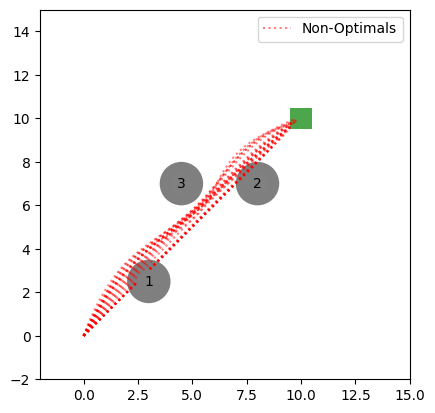

In [85]:
plot_1_set(xs, obs_set, target_high, label='Non-Optimals', linemap_traj='r:', linemap_set='r:')

In [84]:
eigs = np.stack(set_params['Best_eigs'])
dets = np.stack(set_params['Best_dets'])
# plt.plot(dets)
# for d, e in zip(dets, eigs):
#     print('det: ', d, 'eig:' , np.linalg.norm(e))
# print(np.diff(np.linalg.norm(eigs,axis=1))==0)
print(np.round(eigs,decimals=10))
# plt.plot(np.linalg.norm(eigs,axis=0))

[[ 0.00000000e+00+0.j  1.03505338e+07+0.j -1.30000000e-09+0.j
   0.00000000e+00+0.j  0.00000000e+00-0.j  0.00000000e+00+0.j]
 [ 9.20047449e+06+0.j  0.00000000e+00+0.j -5.00000000e-10+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  2.71884280e+08+0.j -0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 2.98977451e+08+0.j -3.00000000e-10+0.j  1.68261889e+05+0.j
   0.00000000e+00+0.j -0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 2.33533233e+06+0.j -0.00000000e+00+0.j  1.65358921e+03+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 2.00187303e+06+0.j  0.00000000e+00+0.j  1.78699055e+03+0.j
   0.00000000e+00+0.j -0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 1.69889495e+06+0.j -0.00000000e+00+0.j  1.79307136e+03+0.j
  -0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 1.44433539e+06+0.j -0.00000000e+00+0.j  1.55023820e+03+0.j
  -0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]


processing the animation ... 
... processing done


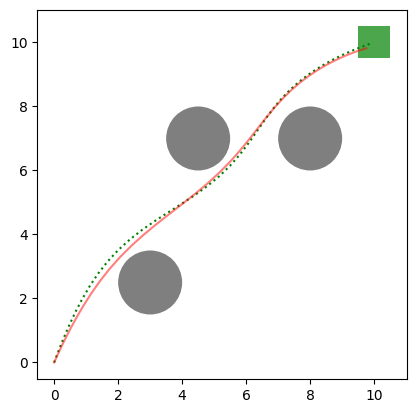

In [86]:
HTML(animateTraj(xs_optimal, xs[:-2], obs_set, target_high, max_set_size, sleep=500, animType=2).to_jshtml())

In [ ]:
w_irl = ws[-3]
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

In [ ]:
print('Desired:                 ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs, us, dt, set_params, Lambda)) 
print('IRL:                     ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs, us, dt, set_params, Lambda))
print('')
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))
print('with IRL Weight:         ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))
print('')
print('IRL Trajectory Cost:     ', cost_set.traj_cost(xs[-1], us[-1], w_irl[:nr], w_irl[nr:], timeStep))
print('with Desired Weight:     ', cost_set.traj_cost(xs[-1], us[-1], w_des[:nr], w_des[nr:], timeStep))

In [ ]:
XS_Set, US_Set = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_irl, timeStep, max_iter, with_callback = False)

In [ ]:
plot_tested_model(XS_Set, obs_set, target_high)

In [ ]:
# Testing
w_run = w_irl[:nr]
w_term = w_irl[nr:]
# w_run = w_des[:nr]
# w_term = w_des[nr:]
# w_run = ws[n][:nr]
# w_term = ws[n][nr:]

x0 = start_point
# x0 = np.array([5.0, 3.5, 0.0, 0.0])
u0 = np.array([0.0, 0.0])

xs_output, us_output, sqp = get_results_from_model(cost_set, x0, u0, T, w_irl, timeStep, max_iter, with_callback = True)

In [ ]:
plot_results(xs_optimal, xs, xs_output, obs_set, target_high)

In [ ]:
P_irl = distributions(cost_set, xs_all[:-2], us_all[:-2], w_irl[:nr], w_irl[nr:], dt)
P_des = distributions(cost_set, xs_all[:-2], us_all[:-2], w_des[:nr], w_des[nr:], dt)

In [ ]:
plt.plot(-1/np.log(P_irl),label='IRL')
plt.plot(-1/np.log(P_des),label='Desired')
plt.legend()
plt.gca().set_title(r'$\frac{-1}{P(\tau)}$')
plt.show()